### big graph


In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numba as nb
import numpy as np
import os
import matplotlib.animation as ma
from AdaptiveInteraction import AdaptiveInteraction2D
from AdaptiveInteraction import StateAnalysis


In [ ]:
N = 100
r_c = 0.5
range_K = np.linspace(0,1,6)
range_J = np.linspace(0,1,6)

models = []
for K in range_K:
    for J in range_J:
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
        models.append(model)

from multiprocessing import Pool

def run_model(model):
    model.run(5000)

with Pool(14) as p:
    p.map(run_model, tqdm(models, total=len(models)))

In [ ]:
N = 100
r_c = 0.5
range_K = np.linspace(0.1,1.1,6)
range_J = np.linspace(0.1,1.1,6)

for K in range_K:
    for J in range_J:
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
        model.run(5000)


In [7]:
import seaborn as sns

sns.set_theme(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

N = 100
K= 1
range_r_c = np.linspace(0.1,1,10)
range_J = np.linspace(0.1,1,10)

fig = plt.figure(figsize=(len(range_K) * 3, len(range_J) * 3)) 

idx = 1

for J in range_J:#纵轴
    for r_c in range_r_c:#横轴
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
        sa = StateAnalysis(model, lookIndex=-1)
        index = -1
        positionX = sa.totalPositionX[index]
        phaseTheta = sa.totalPhaseTheta[index]   
        pointX = sa.totalPointX[index]
        pointTheta = sa.totalPointTheta[index]

        ax = plt.subplot(len(range_K), len(range_J), idx)  # 顺序
        maxAbsPos = np.max(np.abs(positionX)) 
        N = np.sqrt(positionX[:,0]**2 + positionX[:,1]**2)
        # U,V = positionX[:,0]/N, positionX[:,1]/N
        qv = ax.quiver(positionX[:, 0], positionX[:, 1], positionX[:,0]/N, positionX[:,1]/N,
                        phaseTheta,cmap='viridis', clim=(0, 2*np.pi))
        ax.set_xlim(-1.1*maxAbsPos, 1.1*maxAbsPos)
        ax.set_ylim(-1.1*maxAbsPos, 1.1*maxAbsPos)
        ax.set_title(f"$\ J={J:.1f},\ K ={K:.1f},$")

        idx += 1

plt.tight_layout()
if not os.path.exists("./biGraph"):
    os.makedirs("./biGraph")
plt.savefig(f"./biGraph/bigGraph{r_c}.png", dpi=200, bbox_inches="tight")
plt.close()

### order parameter

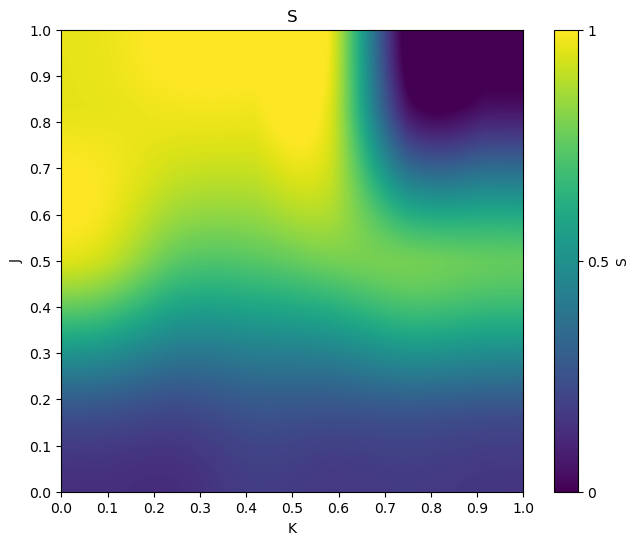

In [10]:
N = 100
r_c = 0.5
range_K = np.linspace(0.1,1.1,6)
range_J = [0.1, 0.5, 1.1]
# range_K = np.linspace(0,1,6)
# range_J = np.linspace(0,1,6)
S_values = np.zeros((len(range_J), len(range_K)))

for i, K in enumerate(range_K): #横轴
    for j, J in enumerate(range_J):# 纵轴
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
        # model.run(2000)

        targetPath = f"./data/{model}.h5"
        totalPositionX = pd.read_hdf(targetPath, key="positionX")
        totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
        TNum = totalPositionX.shape[0] // model.agentsNum

        totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
        transient_index = int(0.9*totalPositionX.shape[0])
        totalPosition_x = totalPositionX[:, :, 0][transient_index:-1]
        totalPosition_y = totalPositionX[:, :, 1][transient_index:-1]
        totalPhaseTheta = totalPhaseTheta.values.reshape(
            TNum, model.agentsNum)[transient_index:-1]

        num_osc = len(totalPosition_x)

        phi = np.arctan2(totalPosition_y, totalPosition_x)
        W_plus = np.exp(1j*(phi + totalPhaseTheta))
        W_minus = np.exp(1j*(phi - totalPhaseTheta))
        row, col = W_plus.shape

        time_OP_plus = np.sum(W_plus, axis=1)/row
        time_OP_minus = np.sum(W_minus, axis=1)/row
        time_OP_plus = np.abs(time_OP_plus)
        time_OP_minus = np.abs(time_OP_minus)
        S_plus = np.sum(time_OP_plus, axis=0)/col
        S_minus = np.sum(time_OP_minus, axis=0)/col

        S = max(S_plus, S_minus)

        S_values[j, i] = S

# 绘制热图

# 设置图片尺寸（6，5）
fig = plt.figure(figsize=(8, 6))
plt.imshow(S_values, cmap='viridis', origin='lower',
           extent=[0, 1, 0, 1], interpolation='spline16') # cmap表示颜色，origin表示原点在左下角，extent表示坐标范围
# 设置x轴和y轴刻度
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
# plt.colorbar(label='S',ticks=[0, 0.5, 1])
cbar = plt.colorbar(label='S', ticks=[0, 0.5, 1])
plt.clim(0, 1)
plt.grid(False)
cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xlabel('K')
plt.ylabel('J')
plt.title('S')
# 判断是否存在OP文件夹，不存在则创建
if not os.path.exists("./OP"):
    os.makedirs("./OP")
plt.savefig('./OP/S.png')
plt.show()

In [13]:
print(pd.DataFrame(S_values, index=range_J, columns=range_K))
print(S_values)

          0.1       0.3       0.5       0.7       0.9       1.1
0.1  0.240198  0.210862  0.254034  0.245060  0.253300  0.237002
0.5  0.922614  0.746237  0.736356  0.786814  0.789762  0.764022
1.1  0.962291  0.980711  0.979240  0.948514  0.047199  0.044883
[[0.24019788 0.21086227 0.25403396 0.24506016 0.25329984 0.23700152]
 [0.92261356 0.74623728 0.7363557  0.78681433 0.7897622  0.76402224]
 [0.96229051 0.98071081 0.9792405  0.94851389 0.04719909 0.04488301]]


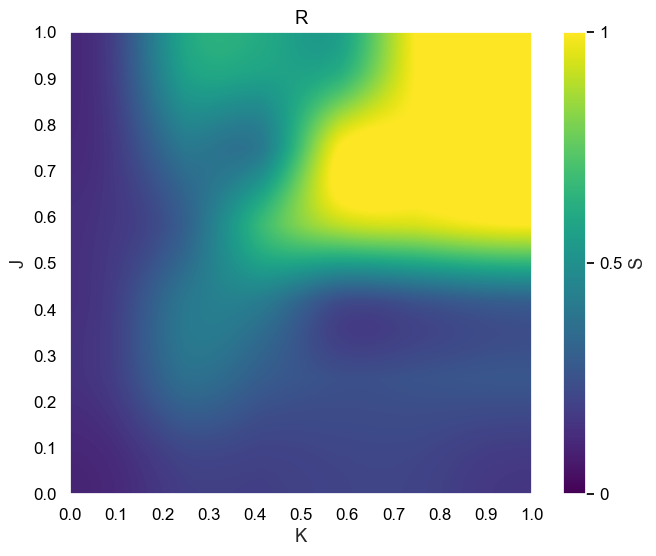

In [11]:
N = 100
K= 1
range_r_c = np.linspace(0.1,1,10)
range_J = np.linspace(0.1,1,10)

R_values = np.zeros((len(range_J), len(range_K)))

for i, r_c in enumerate(range_r_c):
    for j, J in enumerate(range_J):
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
        # model.run(2000)

        # 计算S的值
        targetPath = f"./data/{model}.h5"
        totalPositionX = pd.read_hdf(targetPath, key="positionX")
        totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
        TNum = totalPositionX.shape[0] // model.agentsNum

        totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
        transient_index = int(0.9*totalPositionX.shape[0])
        totalPosition_x = totalPositionX[:, :, 0][transient_index:-1]
        totalPosition_y = totalPositionX[:, :, 1][transient_index:-1]
        totalPhaseTheta = totalPhaseTheta.values.reshape(
            TNum, model.agentsNum)[transient_index:-1]
        

        R_time = np.exp(1j * phaseTheta)
        R = np.abs(np.mean(R_time, axis=1))
        R = np.mean(R)

        R_values[j, i] = R

# 绘制热图

# 设置图片尺寸（6，5）
fig = plt.figure(figsize=(8, 6))
plt.imshow(R_values, cmap='viridis', origin='lower',
           extent=[0, 1, 0, 1], interpolation='spline16') # imshow 读取数据的顺序
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
# plt.colorbar(label='S',ticks=[0, 0.5, 1])
plt.grid(False)
cbar = plt.colorbar(label='S', ticks=[0, 0.5, 1])
plt.clim(0, 1)
cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xlabel('K')
plt.ylabel('J')
plt.title('R')
if not os.path.exists("./OP"):
    os.makedirs("./OP")
plt.savefig('./OP/R.png')
plt.show()

In [12]:
pd.DataFrame(R_values, index=range_J, columns=range_K)

,0.1,0.3,0.5,0.7,0.9,1.1
0.1,0.120164,0.207114,0.199088,0.210338,0.210476,0.177386
0.3,0.171708,0.362751,0.291938,0.246066,0.254883,0.267408
0.5,0.172427,0.395768,0.413915,0.231885,0.253203,0.292723
0.7,0.159424,0.310770,0.678690,0.897636,0.938015,0.990112
0.9,0.155049,0.399374,0.412367,0.999195,0.999643,0.999678
1.1,0.170824,0.567457,0.582282,0.620857,0.999689,0.999746


### animation

In [5]:
J = 0.4
K = 0.8
r_c = 0.5
N = 100
model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
# model.run(2000)
# model.plot()

In [6]:
def draw_mp4(model, savePath: str = "./data", mp4Path: str = "./mp4",step: int = 1):
    
    targetPath = f"{savePath}/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointX = pd.read_hdf(targetPath, key="pointX")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum,2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointX = totalPointX.values.reshape(TNum, model.agentsNum,2)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    maxAbsPos = np.max(np.abs(totalPositionX)) 

    def plot_frame(i):
        pbar.update(1)
        positionX = totalPositionX[i]
        phaseTheta = totalPhaseTheta[i]
        pointX = totalPointX[i]
        pointTheta = totalPointTheta[i]
        fig.clear() # Clear the previous frame
        ax1 = plt.subplot(1, 1, 1)
        ax1.quiver(positionX[:, 0], positionX[:, 1], pointX[:,0], pointX[:, 1],
                        phaseTheta,cmap='viridis', clim=(0, 2*np.pi))
        # ax1.scatter(positionX[:,0], positionX[:,1], c=phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi,s=10) # 点的大小用参数s控制，默认是20
        ax1.set_xlim(-1.1*maxAbsPos, 1.1*maxAbsPos) 
        ax1.set_ylim(-1.1*maxAbsPos, 1.1*maxAbsPos) 
        roundBound = np.round(maxAbsPos) # 四舍五入
        ax1.set_xticks([-roundBound, -roundBound / 2, 0, roundBound / 2, roundBound]) # 设置x轴刻度
        ax1.set_yticks([-roundBound, -roundBound / 2, 0, roundBound / 2, roundBound])   # 设置y轴刻度

    frames = np.arange(0, TNum, step) # 生成帧数
    pbar = tqdm(total=len(frames))
    fig, ax = plt.subplots(figsize=(5, 5))
    ani = ma.FuncAnimation(fig, plot_frame, frames=frames, interval=50, repeat=False)
    # 判断是否存在mp4文件夹，不存在则创建
    if not os.path.exists(mp4Path):
        os.makedirs(mp4Path)
    ani.save(f"{mp4Path}/{model}.mp4", dpi=200) # dpi是分辨率
    plt.close()

    pbar.close()


In [7]:
draw_mp4(model)

  0%|          | 0/1001 [00:00<?, ?it/s]

d:\ProgramData\anaconda3\Lib\site-packages\matplotlib\quiver.py:627: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
d:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
